# A Q learning agent for automated trading in equity stock markets 


# Requirements:


In [1]:
import finpy_tse as fpy  # library for getting daily price
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import ta   # technical indicators
import pandas as pd
import random
import itertools # for creating all combinations - cartesian product

# Getting Historical Data:

In [2]:
TICKER = "TSLA"
START = "2020-01-01"
END = "2024-12-31"
df = yf.download(TICKER, start=START, end=END, progress=False , auto_adjust=True)

In [3]:
df.columns = df.columns.get_level_values(0)
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


 In the following code snippet, we first select the key columns from the dataset and then use the adjusted closing price to compute both the simple return and the percentage return.﻿

The adjusted closing price is the closing price that has been corrected for corporate actions such as capital increases and cash dividend payments, allowing for a more accurate analysis of the stock’s trend and total return, since the share price typically falls when dividends are paid.﻿

Finally, we compute the RSI indicator using the ta library.

In [4]:
df = df[['Volume','Close','Open']]
df["return"] = df["Close"].diff()
df["percentage return"] = df["Close"].pct_change()
df['rsi'] = ta.momentum.rsi(df['Close'], window=14, fillna=False) # window=14 means we use 14 previous days to calculate RSI
# df['rsi'] = RSIIndicator(close=df["Adj Close"].squeeze(), window=14).rsi()

# source: https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.momentum.RSIIndicator

# (Relative Strength Index)RSI Formula:


$$
RSI_{\text{step one}} = 100 - \left[ \frac{100}{1 + \frac{\text{Average gain}}{\text{Average loss}}} \right]
$$

Note: As you can see in the table below, computing this indicator requires data from the previous 14 days, so the first 13 rows of the table will contain NaN values. If the value of this indicator is greater than 70, it means the asset is overbought and demand has been elevated for some time; the price has already increased significantly, which we interpret as a sell signal. Conversely, if the value of this indicator is less than 30, it means the asset is oversold and there has been heavy selling pressure; the price has declined sufficiently, which we interpret as a buy signal. When the indicator lies between 30 and 70, we do not take any action (Hold).

[Source : https://www.investopedia.com/terms/r/rsi.asp ](https://www.investopedia.com/terms/r/rsi.asp)

In [5]:
df.iloc[:14,:]

Price,Volume,Close,Open,return,percentage return,rsi
Date,,,,,,
2020-01-02,142981500,28.684000,28.299999,NaN,NaN,NaN
2020-01-03,266677500,29.534000,29.366667,0.850000,0.029633,NaN
2020-01-06,151995000,30.102667,29.364668,0.568666,0.019255,NaN
2020-01-07,268231500,31.270666,30.760000,1.167999,0.038801,NaN
2020-01-08,467164500,32.809334,31.580000,1.538668,0.049205,NaN
2020-01-09,426606000,32.089333,33.139999,-0.720001,-0.021945,NaN
2020-01-10,194392500,31.876667,32.119331,-0.212666,-0.006627,NaN
2020-01-13,397764000,34.990665,32.900002,3.113998,0.097689,NaN
2020-01-14,434943000,35.861332,36.284000,0.870667,0.024883,NaN


In [6]:
df.describe()

Price,Volume,Close,Open,return,percentage return,rsi
count,1.257000e+03,1257.000000,1257.000000,1256.000000,1256.000000,1244.000000
mean,1.255755e+08,213.279443,213.315219,0.309495,0.003026,53.308330
std,8.211007e+07,83.321515,83.449250,8.837817,0.042325,13.889507
min,2.940180e+07,24.081333,24.980000,-46.480011,-0.210628,16.564126
25%,7.600980e+07,173.860001,173.889999,-3.642498,-0.019882,43.982370
50%,1.019936e+08,220.190002,220.916672,0.343330,0.001912,52.501329
75%,1.454174e+08,259.670013,259.209991,4.450001,0.023789,62.832843
max,9.140820e+08,479.859985,475.899994,47.666656,0.219190,94.197983


<hr style="height:3px;color:red;background-color:red">

### The following command removes all rows that contain NaN values. Therefore, we expect the first 14 rows to be dropped.

In [7]:
df = df.dropna()
df.head()

Price,Volume,Close,Open,return,percentage return,rsi
Date,,,,,,
2020-01-22,470535000,37.970669,38.125999,1.490669,0.040863,81.175832
2020-01-23,294765000,38.146667,37.616669,0.175999,0.004635,81.518133
2020-01-24,215304000,37.654667,38.042000,-0.492001,-0.012898,77.287147
2020-01-27,204121500,37.201332,36.132668,-0.453335,-0.012039,73.501652
2020-01-28,176827500,37.793331,37.899334,0.591999,0.015913,75.209273


<hr style="height:3px;color:red;background-color:red">

# Discretization:



### Next, we discretize the continuous variables—trading volume, return, and RSI—into a finite number of bins. We define the discretization scheme for the stock return as follows:

\begin{cases}
\text{Down} & \text{if } \: \text{return} \leq -1\% \\
\text{Flat} & \text{if } \: -1\% < \text{return} \leq 1\% \\
\text{Up} & \text{if } \: \text{return} > 1\%
\end{cases}


In [8]:
df['returns_binned'] = pd.cut( df["return"], [-np.inf, -0.01, 0.01, np.inf], labels=["Down", "Flat", "Up"] , right=True)

In [9]:
df.returns_binned.value_counts().sort_index() #testing

returns_binned
Down    582
Flat      2
Up      660
Name: count, dtype: int64

<hr style="height:3px;color:red;background-color:red">

### We define the discretization of the RSI indicator as follows:﻿

\begin{cases}
0 \leq \text{RSI} \leq 30 & \text{Oversold} \\
30 < \text{RSI} \leq 70 & \text{Neutral} \\
70 < \text{RSI} \leq 100 & \text{Overbought}
\end{cases}

In [10]:
df['rsi_binned'] = pd.cut( df["rsi"], [-np.inf, 30, 70, np.inf], labels=["Oversold", "Neutral", "Overbought"] )

In [11]:
df.rsi_binned.value_counts().sort_index()  #testing

rsi_binned
Oversold        57
Neutral       1042
Overbought     145
Name: count, dtype: int64

<hr style="height:3px;color:red;background-color:red">

### We define the discretization of trading volume as follows:

\begin{cases}
\text{low}, & Volume < 50,000,000 \\
\text{medium}, & 50,000,000 \leq Volume < 150,000,000 \\
\text{high}, & Volume \geq 150,000,000
\end{cases}

In [12]:
def volume_level(v):
    if v < 50000000:
        return "low"
    elif v < 150000000:
        return 'medium'
    else:
        return "high"

df['Volume_binned'] = df['Volume'].apply(volume_level)

In [13]:
df.Volume_binned.value_counts().sort_index()

Volume_binned
high      282
low        50
medium    912
Name: count, dtype: int64

In [14]:
df['cash'] = 0
df['cash'] = df['cash'].astype(float)
df['action'] = ""
df['action1'] = ""

In [15]:
df = df.reset_index(drop=True)
df.head()

Price,Volume,Close,Open,return,percentage return,rsi,returns_binned,rsi_binned,Volume_binned,cash,action,action1
0,470535000,37.970669,38.125999,1.490669,0.040863,81.175832,Up,Overbought,high,0.0,,
1,294765000,38.146667,37.616669,0.175999,0.004635,81.518133,Up,Overbought,high,0.0,,
2,215304000,37.654667,38.042000,-0.492001,-0.012898,77.287147,Down,Overbought,high,0.0,,
3,204121500,37.201332,36.132668,-0.453335,-0.012039,73.501652,Down,Overbought,high,0.0,,
4,176827500,37.793331,37.899334,0.591999,0.015913,75.209273,Up,Overbought,high,0.0,,


<hr style="height:3px;color:red;background-color:red">

### In the following code snippet, we split the dataset into training and test sets.﻿

In [16]:
n = len(df)
test_size = int(n*0.2)
train = df.iloc[:n - test_size]
test = df.iloc[n - test_size:]
print(train.shape)
print(test.shape)

(996, 12)
(248, 12)


<hr style="height:3px;color:red;background-color:red">

### In this section, we define the Agent class, which takes the number of actions and states, along with the hyperparameters and a seed (for reproducibility and hyperparameter tuning), as input.

<div justify-content: center; >
<img src="https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png" alt="Girl in a jacket" width="800" height="900">
</div>





In [17]:
class Agent:
    def __init__(self,agent_info):
        self.num_actions = agent_info["num_actions"]
        self.num_states = agent_info["num_states"]
        self.epsilon = agent_info["epsilon"] #hyper parameter
        self.epsilon_decay = 0.8 #0.95
        self.epsilon_min = 0.001
        self.step_size = agent_info["step_size"] #hyper parameter
        self.discount = agent_info["discount"] #hyper parameter
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        # self.Q = np.zeros((self.num_states, self.num_actions))       
        returns = ["Down", "Flat", "Up"]
        rsi = ["Oversold", "Neutral", "Overbought"]
        volume = ['low','medium','high']
        states = list(itertools.product(returns, rsi, volume)) # gives all cominations - cartesian product
        actions = [2, 0, 1]   # Short - Hold - Long
        self.Q = pd.DataFrame(0,index=pd.MultiIndex.from_tuples(states, names=['Return_binned', 'RSI_binned', 'Volume_binned']), columns=actions)

    # Epsilon-greedy Action selection
    def getAction(self,state):
        if self.rand_generator.rand() < self.epsilon:
            return self.rand_generator.choice([2,0,1])
        else:
            # print(self.Q.loc[state])
            # print(self.Q.loc[state].idxmax())
            # return np.argmax(self.Q.loc[state]) 
            return self.Q.loc[state].idxmax()
         
    # Q-learning Update
    def update(self,state,action,reward,next_state):
            self.Q.loc[state,action]= self.Q.loc[state,action] + (self.step_size * (reward + (self.discount * np.max(self.Q.loc[next_state, :]))
                                                                - self.Q.loc[state,action]))


In [18]:
# class Agent:
#     def __init__(self):
#         self.epsilon = 1
#         self.gamma = 0.618
#         self.epsilon_decay = 0.9995
#         self.epsilon_min = 0.01
#         # self.Q = np.matrix(np.zeros([12,3]))   
#         self.Q = np.random.uniform(low=0, high=0.01, size=(12,3))
#         self.learning_rate=0.06
#         # self.rand_generator = np.random.RandomState(42)
        
#     def getAction(self,state):
#         a=[1,0,2]
#         if np.random.rand() <= self.epsilon:
#             return random.choice(a)
#         return np.argmax(self.Q[state,]) 
         
#     # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
#     def update(self,state,action,reward,next_state,next_action):            
#             self.Q[state,action]= self.Q[state,action] + self.learning_rate * (reward + self.gamma * np.max(self.Q[next_state, :])
#                                                                 - self.Q[state,action])

<hr style="height:3px;color:red;background-color:red">

# State and Reward Definition : 


The environment states are represented as tuples with three components, defined as follows:

$$\mathcal{S} = \left\{ (r, rsi , v) \mid r \in \text{return binned},\; rsi \in \text{RSI binned},\; v \in \text{volume binned} \right\}
$$

 In fact, the action only influences our reward. For example, if we took a long position on the first day and prices increase on the second day, we make a profit; conversely, if prices decrease on the second day, we incur a loss.


In [19]:
def get_state(row):
    return (row['returns_binned'],
            row['rsi_binned'],
            row['Volume_binned']
            )

<hr style="height:3px;color:red;background-color:red">

### In the following section, we create an instance of the Agent class and pass the initial values as a dictionary.

In [20]:
# np.random.seed(42)

# num_states = num_rsi * num_volume * num_returns
num_states = 3 * 3 * 3

agent_info = {"num_actions": 3, "num_states": num_states, "epsilon": 1, "step_size": 0.06, "discount": 0.618, "seed": 0}
agent = Agent(agent_info)

<hr style="height:3px;color:red;background-color:red">

 As you will see, the tabular Q-learning table, in which each row corresponds to a three-component state, is initialized with zeros.﻿

In [21]:
# agent.Q.loc[('Flat', 'Overbought', 'low'), 0]  # How to Access values of table
agent.Q

2  0  1
Return_binned RSI_binned Volume_binned         
Down          Oversold   low            0  0  0
                         medium         0  0  0
                         high           0  0  0
              Neutral    low            0  0  0
                         medium         0  0  0
                         high           0  0  0
              Overbought low            0  0  0
                         medium         0  0  0
                         high           0  0  0
Flat          Oversold   low            0  0  0
                         medium         0  0  0
                         high           0  0  0
              Neutral    low            0  0  0
                         medium         0  0  0
                         high           0  0  0
              Overbought low            0  0  0
                         medium         0  0  0
                         high           0  0  0
Up            Oversold   low            0  0  0
                         medium         0  0  0
                         high           0  0  0
              Neutral    low            0  0  0
                         medium         0  0  0
                         high           0  0  0
              Overbought low            0  0  0
                         medium         0  0  0
                         high           0  0  0

In [22]:
# X.loc[1,'Open']

<hr style="height:3px;color:red;background-color:red">

# Training:
In the following section, we run the Q-learning loop on the training data and add auxiliary variables for generating analytical plots.﻿

In [23]:
episode_count=200
# agent=Agent()
m1=0
m2=0
cumulative_returns1 = []
buyandholds = []
# kmeans = KMeans(n_clusters=5, random_state=0).fit(X[['O','H','L','C','V']].values) 
for e in range(1,episode_count+1):
    # buyandhold = 0
    X = df.copy()
    # kmeans = KMeans(n_clusters=3, random_state=0).fit(X[['O','H','L','C','V','weekday']].values) 
    data_length_start= 0
    data_length= train.shape[0]-1
    state = get_state(X.iloc[0,:])
    action = agent.getAction(state)
    last_action=None
    last_price=0
    last_quantity=0
    capital=X.loc[data_length_start,'Open']*100   # we can buy 100 stocks
    margin=X.loc[data_length_start,'Open']*100
    brok_rate=0.0005
    profit=0    
    # print("Episod {}/{}".format(e,episode_count))
    count=0  # number of positions with opening and closing
    for t in range(data_length_start,data_length-1):
        # print(X.loc[t,'Open'])
        #print('t',t)        
        reward=0
        if last_action=='sold':
            tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate
            tprofit=(last_price-X.loc[t,'Open'])*last_quantity
            if last_quantity == 0 or last_price == 0 or np.isnan(last_price):
                tprofit1 = 0
            else:
                tprofit1 = (tprofit / (last_price * last_quantity)) * 100
            if tprofit1<-10: # preventing loss
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit) # cash of trader before short + profit of short
                X.loc[t,'cash']=margin      
                #print('close short stop loss @',X['Open'].iloc[t])
                last_action=None
                X.loc[t,'action']="close short"
                X.loc[t,'action1']="long"
                reward= max((np.log(last_price)-np.log(X.loc[t,'Open'])),0)
        elif last_action=='bought':
            tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate
            tprofit=(X.loc[t,'Open']-last_price)*last_quantity
            if last_quantity == 0 or last_price == 0 or np.isnan(last_price):
                tprofit1 = 0
            else:
                tprofit1 = (tprofit / (last_price * last_quantity)) * 100
            if tprofit1<-10:
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit)
                X.loc[t,'cash']=margin        
                #print('close long stop loss @',X.loc[t,'Open'])
                last_action=None
                X.loc[t,'action']="close long"
                X.loc[t,'action1']="short"
                reward= max((np.log(X.loc[t,'Open'])-np.log(last_price)),0)               
                          
            
        if action == 1  and last_action==None :
            #print('in long')
            X.loc[t,'cash']=margin  # all money          
            last_quantity=margin//X.loc[t,'Open']   # number of stock you can buy
            margin=margin%X.loc[t,'Open']  # remaining money 
            last_price=X.loc[t,'Open']
            last_action='bought'
            #print('open long @',last_price)
            X.loc[t,'action']="open long"
            X.loc[t,'action1']="long"
            count=count+1
        elif action == 1  and last_action=='sold':
            #print('in close short')
            tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate  # faghat moghe bastan ????
            tprofit=(last_price-X.loc[t,'Open']-tbrokerage)*last_quantity
            if last_quantity == 0 or last_price == 0 or np.isnan(last_price):
                tprofit1 = 0
            else:
                tprofit1 = (tprofit / (last_price * last_quantity)) * 100
            if tprofit1>3 or tprofit1<-3:
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit)  # cash of trader + profit of short   |:
                X.loc[t,'cash']=margin      
                #print('close short @',X.loc[t,'Open'])
                last_action=None
                X.loc[t,'action']="close short"
                X.loc[t,'action1']="long"
                reward= max((np.log(last_price)-np.log(X.loc[t,'Open']+tbrokerage)),0)
            else:                                                                      # don't close short position
                tp=(last_price-X.loc[t,'Close'])*last_quantity  # profit of short from start till now
                original=margin+(last_quantity*last_price) # cash of trader
                X.loc[t,'cash']=original+tp   
                
        elif action == 1  and last_action=='bought':
            #print('in hold long')
            X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close'])
        elif action == 2  and last_action==None and margin>X.loc[t,'Open']:
            #print('in short')
            X.loc[t,'cash']=margin        
            last_quantity=margin//X.loc[t,'Open']   # excessive
            margin=margin%X.loc[t,'Open']           # excessive
            last_price=X.loc[t,'Open']              # short price
            last_action='sold'        
            #print('open short @',last_price)
            X.loc[t,'action']="open short"
            X.loc[t,'action1']="short"      
            count=count+1
        elif action == 2 and  last_action=='bought':#close long
            #print('in close long')
            tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate    # faghat moghe bastan ????
            tprofit=(X.loc[t,'Open']-last_price-tbrokerage)*last_quantity
            if last_quantity == 0 or last_price == 0 or np.isnan(last_price):
                tprofit1 = 0
            else:
                tprofit1 = (tprofit / (last_price * last_quantity)) * 100
            if tprofit1>3 or tprofit1<-3:
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit)   # cash of trader when buying + profit
                X.loc[t,'cash']=margin        
                #print('close long @',X.loc[t,'Open'])
                last_action=None
                X.loc[t,'action']="close long"
                X.loc[t,'action1']="short"
                reward= max((np.log(X.loc[t,'Open'])-np.log(last_price+tbrokerage)),0)
            else:                                                          # don't close long
                X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) 
                
            
        elif action == 2  and last_action=='sold':
            #print('in hold short')
            tp=(last_price-X.loc[t,'Close'])*last_quantity  # profit of short from beginning
            original=margin+(last_quantity*last_price)  # cash of trader
            X.loc[t,'cash']=original+tp
        else:   # action = hold         
            if last_action==None:
                X.loc[t,'cash']=margin 
                #print('in hold1')
            elif last_action=='bought':
                X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) 
                #print('in hold2')
            elif last_action=='sold':
                tp=(last_price-X.loc[t,'Close'])*last_quantity  # profit of short from beginning
                original=margin+(last_quantity*last_price)  # cash of trader
                X.loc[t,'cash']=original+tp     
                #print('in hold3')
                                       
        # print("epsilon",agent.epsilon)      
        next_state = get_state(train.iloc[t+1,:])
        next_action = agent.getAction(next_state)
        agent.update(state,action,reward,next_state)
        state = next_state
        action = next_action
        
        if t==data_length-2:
                # print("--------------------------------")
                if  last_action=='sold':
                    tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                    tprofit=(last_price-X.loc[t,'Close']-tbrokerage)*last_quantity
                    profit=profit+tprofit
                    margin=margin+(last_quantity*last_price)+(tprofit) 
                    X.loc[t,'cash']=margin
                    #print('close short @',X.loc[t,'Close'])
                    last_action=None
                    X.loc[t,'action']="close short"
                    X.loc[t,'action1']="long"
                elif last_action=='bought':
                    tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                    tprofit=(X.loc[t,'Close']-last_price-tbrokerage)*last_quantity
                    profit=profit+tprofit
                    margin=margin+(last_quantity*last_price)+(tprofit) 
                    X.loc[t,'cash']=margin
                    #print('close long @',X.loc[t,'Close'])
                    last_action=None
                    X.loc[t,'action']="close long"
                    X.loc[t,'action1']="short"
                # print("\n***********************")
                # print("Profit is ",profit)
                # print("Initial Capital is ",capital)    
                # print("Current Capital is ",margin)
                # roi=((margin-capital)/capital)*100
                # print("%ROI is ",roi)
                bnh=((X.loc[t,'Close']-X.loc[data_length_start,'Close'])/X.loc[data_length_start,'Close'])*100
                # print("% Buy and Hold=",bnh)
                # print("count",count)
                # print("qtable",agent.Q)
                # print("epsilon",agent.epsilon)
                # print("--------------------------------")
                       
    if (agent.epsilon > agent.epsilon_min) and e>1:
                    agent.epsilon *= agent.epsilon_decay

        # buyandhold += X.iloc[t+1,28] 

    # print(last_quantity)   
    buyandholds.append(bnh)
    cumulative_returns1.append(profit)
    # print(cumulative_returns)
#     m3=roi
#     if m3>m2:
#         m1=e
#         m2=m3
#     #To save model            
#     np.save('rl/Qtable'+ str(e)+str('.npy'), agent.Q)
#     np.save('rl/epsilon'+ str(e)+str('.npy'), agent.epsilon)
#     np.save('rl/gamma'+ str(e)+str('.npy'), agent.gamma)
#     np.save('rl/learning_rate'+ str(e)+str('.npy'), agent.learning_rate)
#     X.to_csv('csv/AfterTrain'+str(e)+str('.csv'))
# print("e={},roi={}".format(m1,m2))

C:\Users\msi\AppData\Local\Temp\ipykernel_8660\1159799493.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009896360291133038' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.Q.loc[state,action]= self.Q.loc[state,action] + (self.step_size * (reward + (self.discount * np.max(self.Q.loc[next_state, :]))
C:\Users\msi\AppData\Local\Temp\ipykernel_8660\1159799493.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.004138326190565636' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.Q.loc[state,action]= self.Q.loc[state,action] + (self.step_size * (reward + (self.discount * np.max(self.Q.loc[next_state, :]))
C:\Users\msi\AppData\Local\Temp\ipykernel_8660\1159799493.py:31: FutureWarning: Setting an item of incompatible dtype is dep

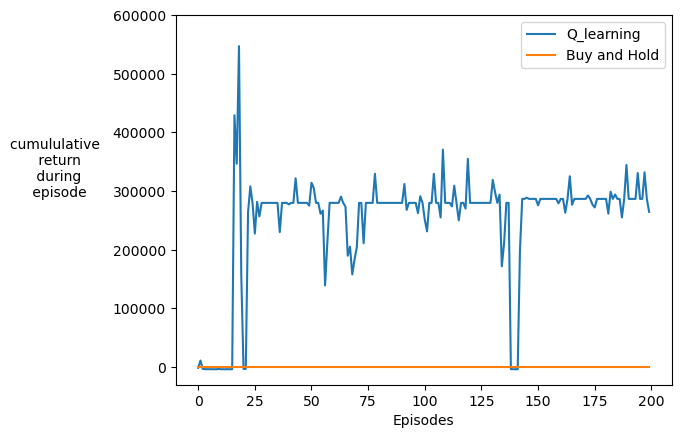

In [24]:
plt.plot(cumulative_returns1, label= "Q_learning")
plt.plot(buyandholds, label="Buy and Hold")
plt.xlabel("Episodes")
plt.ylabel("cumululative \n return\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-30000,600000)
plt.legend()
plt.show()

In [25]:
print(buyandholds[0])

554.2418294632303


<hr style="height:3px;color:red;background-color:red">

# testing

In [26]:
# episode_count=100
m1=0
m2=0
# agent.epsilon = 0
cumulative_returns = []
buyandholds2 = []
# kmeans = KMeans(n_clusters=5, random_state=0).fit(X[['O','H','L','C','V']].values) 

# buyandhold = 0
X = df.copy()
# kmeans = KMeans(n_clusters=3, random_state=0).fit(X[['O','H','L','C','V','weekday']].values) 
data_length_start= train.shape[0]
data_length= X.shape[0]-1
state = get_state(X.iloc[data_length_start,:])
action = agent.getAction(state)
last_action=None
last_price=0
last_quantity=0
capital=X.loc[data_length_start,'Open']*100   # we can buy 100 stocks
margin=X.loc[data_length_start,'Open']*100
# print(margin)
brok_rate=0.0005
profit=0   
daily_profit= []
# print("Episod {}/{}".format(e,episode_count))
count=0  # number of positions with opening and closing
for t in range(data_length_start,data_length-1):
    # print(last_action)
    # print(action)
    #print('t',t)        
    reward = 0
    if last_action=='sold':
        tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate
        tprofit=(last_price-X.loc[t,'Open'])*last_quantity
        tprofit1=(tprofit/(last_price*last_quantity))*100
            
        if tprofit1<-10: # preventing loss
            profit=profit+tprofit
            margin=margin+(last_quantity*last_price)+(tprofit) # cash of trader before short + profit of short
            X.loc[t,'cash']=margin      
            #print('close short stop loss @',X['Open'].iloc[t])
            last_action=None
            X.loc[t,'action']="close short"
            X.loc[t,'action1']="long"
            reward= max((np.log(last_price)-np.log(X.loc[t,'Open'])),0)
    elif last_action=='bought':
        tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate
        tprofit=(X.loc[t,'Open']-last_price)*last_quantity
        tprofit1=(tprofit/(last_price*last_quantity))*100
        if tprofit1<-10:
            profit=profit+tprofit
            margin=margin+(last_quantity*last_price)+(tprofit)
            X.loc[t,'cash']=margin        
            #print('close long stop loss @',X.loc[t,'Open'])
            last_action=None
            X.loc[t,'action']="close long"
            X.loc[t,'action1']="short"
            reward= max((np.log(X.loc[t,'Open'])-np.log(last_price)),0)               
                          
            
    if action == 1  and last_action==None :
        #print('in long')
        X.loc[t,'cash']=margin  # all money          
        last_quantity=margin//X.loc[t,'Open']   # number of stock you can buy
        margin=margin%X.loc[t,'Open']  # remaining money 
        last_price=X.loc[t,'Open']
        last_action='bought'
        #print('open long @',last_price)
        X.loc[t,'action']="open long"
        X.loc[t,'action1']="long"
        count=count+1
    elif action == 1  and last_action=='sold':
        #print('in close short')
        tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate  # faghat moghe bastan ????
        tprofit=(last_price-X.loc[t,'Open']-tbrokerage)*last_quantity
        tprofit1=(tprofit/(last_price*last_quantity))*100
        if tprofit1>3 or tprofit1<-3:
            profit=profit+tprofit
            margin=margin+(last_quantity*last_price)+(tprofit)  # cash of trader + profit of short   |:
            X.loc[t,'cash']=margin      
            #print('close short @',X.loc[t,'Open'])
            last_action=None
            X.loc[t,'action']="close short"
            X.loc[t,'action1']="long"
            reward= max((np.log(last_price)-np.log(X.loc[t,'Open']+tbrokerage)),0)
        else:                                                                      # don't close short position
            tp=(last_price-X.loc[t,'Close'])*last_quantity  # profit of short from start till now
            original=margin+(last_quantity*last_price) # cash of trader
            X.loc[t,'cash']=original+tp   
                
    elif action == 1  and last_action=='bought':
        #print('in hold long')
        X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close'])
    elif action == 2  and last_action==None and margin>X.loc[t,'Open']:
        #print('in short')
        X.loc[t,'cash']=margin        
        last_quantity=margin//X.loc[t,'Open']   # excessive
        margin=margin%X.loc[t,'Open']           # excessive
        last_price=X.loc[t,'Open']              # short price
        last_action='sold'        
        #print('open short @',last_price)
        X.loc[t,'action']="open short"
        X.loc[t,'action1']="short"      
        count=count+1
    elif action == 2 and  last_action=='bought':#close long
        # print('in close long')
        tbrokerage=(X.loc[t,'Open']+last_price)*brok_rate    # faghat moghe bastan ????
        tprofit=(X.loc[t,'Open']-last_price-tbrokerage)*last_quantity
        tprofit1=(tprofit/(last_price*last_quantity))*100
        if tprofit1>3 or tprofit1<-3:
            profit=profit+tprofit
            margin=margin+(last_quantity*last_price)+(tprofit)   # cash of trader when buying + profit
            X.loc[t,'cash']=margin        
            #print('close long @',X.loc[t,'Open'])
            last_action=None
            X.loc[t,'action']="close long"
            X.loc[t,'action1']="short"
            reward= max((np.log(X.loc[t,'Open'])-np.log(last_price+tbrokerage)),0)
        else:                                                          # don't close long
            X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) 
                
            
    elif action == 2  and last_action=='sold':
        #print('in hold short')
        tp=(last_price-X.loc[t,'Close'])*last_quantity  # profit of short from beginning
        original=margin+(last_quantity*last_price)  # cash of trader
        X.loc[t,'cash']=original+tp
    else:   # action = hold         
        if last_action==None:
             X.loc[t,'cash']=margin 
            #print('in hold1')
        elif last_action=='bought':
            X.loc[t,'cash']=margin+(last_quantity*X.loc[t,'Close']) 
            #print('in hold2')
        elif last_action=='sold':
            tp=(last_price-X.loc[t,'Close'])*last_quantity  # profit of short from beginning
            original=margin+(last_quantity*last_price)  # cash of trader
            X.loc[t,'cash']=original+tp     
            #print('in hold3')
                                       
    # print("epsilon",agent.epsilon)      
    next_state = get_state(X.iloc[t+1,:])
    next_action = agent.getAction(next_state)
    # print(next_action)
    # agent.update(state,action,reward,next_state)
    state = next_state
    action = next_action
        
    if t==data_length-2:
            # print("--------------------------------")
            if  last_action=='sold':
                tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                tprofit=(last_price-X.loc[t,'Close']-tbrokerage)*last_quantity
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit) 
                X.loc[t,'cash']=margin
                #print('close short @',X.loc[t,'Close'])
                last_action=None
                X.loc[t,'action']="close short"
                X.loc[t,'action1']="long"
            elif last_action=='bought':
                tbrokerage=(X.loc[t,'Close']+last_price)*brok_rate
                tprofit=(X.loc[t,'Close']-last_price-tbrokerage)*last_quantity
                profit=profit+tprofit
                margin=margin+(last_quantity*last_price)+(tprofit) 
                X.loc[t,'cash']=margin
                #print('close long @',X.loc[t,'Close'])
                last_action=None
                X.loc[t,'action']="close long"
                X.loc[t,'action1']="short"
            # print("\n***********************")
            # print("Profit is ",profit)
            # print("Initial Capital is ",capital)    
            # print("Current Capital is ",margin)
            # roi=((margin-capital)/capital)*100
            # print("%ROI is ",roi)
            bnh=((X.loc[t,'Close']-X.loc[data_length_start,'Close'])/X.loc[data_length_start,'Close'])*100
            # print("% Buy and Hold=",bnh)
            # print("count",count)
            # print("qtable",agent.Q)
            # print("epsilon",agent.epsilon)
            # print("--------------------------------")
                 
    daily_profit.append(profit)
    
        # buyandhold += X.iloc[t+1,28] 

        
buyandholds2.append(bnh)
cumulative_returns.append(profit)
#     m3=roi
#     if m3>m2:
#         m1=e
#         m2=m3
#     #To save model            
#     np.save('rl/Qtable'+ str(e)+str('.npy'), agent.Q)
#     np.save('rl/epsilon'+ str(e)+str('.npy'), agent.epsilon)
#     np.save('rl/gamma'+ str(e)+str('.npy'), agent.gamma)
#     np.save('rl/learning_rate'+ str(e)+str('.npy'), agent.learning_rate)
#     X.to_csv('csv/AfterTrain'+str(e)+str('.csv'))
# print("e={},roi={}".format(m1,m2))

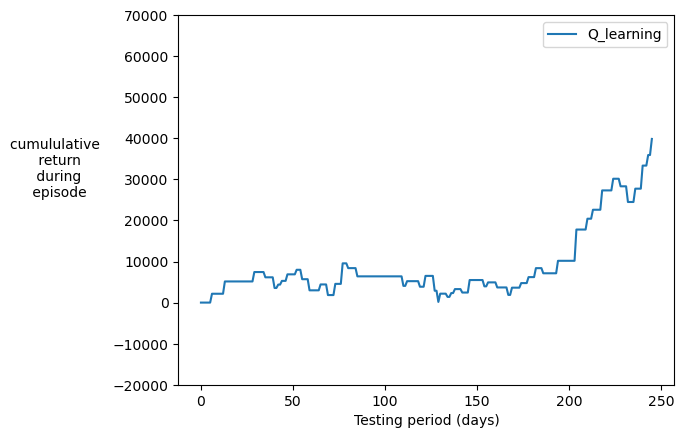

In [27]:
plt.plot(daily_profit, label= "Q_learning")
# plt.plot(buyandholds2, label="Buy and Hold")
plt.xlabel("Testing period (days)")
plt.ylabel("cumululative \n return\n during\n episode",rotation=0, labelpad=40)
plt.ylim(-20000,70000)
plt.legend()
plt.show()